In [21]:
%load_ext autoreload
%autoreload 2

import sys
import os 

import torch
from torch_geometric.data import Data

def create_grid_graph(rows, cols, num_channels):
    num_nodes = rows * cols
    edge_index = []
    
    for i in range(rows):
        for j in range(cols):
            node = i * cols + j
            if j < cols - 1:
                edge_index.append([node, node + 1])
            if i < rows - 1:
                edge_index.append([node, node + cols])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.rand((edge_index.size(1), num_channels), dtype=torch.float)
    
    x = torch.rand((num_nodes, num_channels), dtype=torch.float)
    grid_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return grid_data

def create_mesh_graph(num_nodes, num_channels):
    edge_index = []
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            edge_index.append([i, j])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.rand((edge_index.size(1), num_channels), dtype=torch.float)
    
    x = torch.rand((num_nodes, num_channels), dtype=torch.float)
    mesh_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return mesh_data

def create_g2m_and_m2g_connections(grid_data, mesh_data, num_channels):
    grid_nodes = grid_data.num_nodes
    mesh_nodes = mesh_data.num_nodes
    
    g2m_edge_index = torch.stack([torch.randint(0, grid_nodes, (mesh_nodes,)),
                                  torch.arange(0, mesh_nodes)], dim=0)
    
    m2g_edge_index = torch.stack([torch.arange(0, mesh_nodes),
                                  torch.randint(0, grid_nodes, (mesh_nodes,))], dim=0)
    
    g2m_edge_attr = torch.rand((g2m_edge_index.size(1), num_channels), dtype=torch.float)
    m2g_edge_attr = torch.rand((m2g_edge_index.size(1), num_channels), dtype=torch.float)
    
    return g2m_edge_index, g2m_edge_attr, m2g_edge_index, m2g_edge_attr

def create_custom_graph_dataset(grid_rows, grid_cols, mesh_nodes, num_channels, edge_dim):
    grid_data = create_grid_graph(grid_rows, grid_cols, num_channels)
    mesh_data = create_mesh_graph(mesh_nodes, num_channels)
    
    g2m_edge_index, g2m_edge_attr, m2g_edge_index, m2g_edge_attr = create_g2m_and_m2g_connections(grid_data, mesh_data, edge_dim)
    
    combined_x = torch.cat([grid_data.x, mesh_data.x], dim=0)
    
    mesh_edge_index_shifted = mesh_data.edge_index + grid_data.num_nodes
    
    data = Data(
        x=combined_x,
        g2m_edge_index=g2m_edge_index + torch.tensor([[0], [grid_data.num_nodes]], dtype=torch.long),
        g2m_edge_attr=g2m_edge_attr,
        m2m_edge_index=mesh_edge_index_shifted,
        m2m_edge_attr=mesh_data.edge_attr,
        m2g_edge_index=m2g_edge_index + torch.tensor([[grid_data.num_nodes], [0]], dtype=torch.long),
        m2g_edge_attr=m2g_edge_attr
    )
    
    return data

dataset = create_custom_graph_dataset(
    grid_rows=2,
    grid_cols=2,
    mesh_nodes=4,
    num_channels=32,  # Node feature dimension
    edge_dim=32  # Edge feature dimension
)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:

import sys
import torch




from sdk.ample import Ample

from torch_geometric.datasets import FakeDataset #TODO remove
from sdk.models.models import MLP_Model,Interaction_Net_Model,GCN_Model

from torch_geometric.data import Data


class Graphcast(torch.nn.Module):
    def __init__(self, in_channels=32, out_channels=32, layer_count=1, hidden_dimension=32, precision = torch.float32):
        super().__init__()
        self.precision = precision
        self.layers = torch.nn.ModuleList()
       
        self.grid_mesh_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.grid_mesh_embedder.name  = 'grid_mesh_embedder'
        self.layers.append(self.grid_mesh_embedder) 

        self.g2m_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.g2m_embedder.name  = 'g2m_embedder'
        self.layers.append(self.g2m_embedder) 

        self.g2m_int_net = Interaction_Net_Model()
        self.g2m_int_net.name  = 'g2m_int_net'
        self.layers.append(self.g2m_int_net) 

        self.m2m_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.m2m_embedder.name  = 'm2m_embedder'
        self.layers.append(self.m2m_embedder) 

        self.m2m_int_net = Interaction_Net_Model()
        self.m2m_int_net.name  = 'm2m_int_net'
        self.layers.append(self.m2m_int_net) 

        self.m2g_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.m2g_embedder.name  = 'm2m_embedder'
        self.layers.append(self.m2g_embedder) 
 
        self.m2g_int_net = Interaction_Net_Model()
        self.m2g_int_net.name  = 'm2m_int_net'
        self.layers.append(self.m2g_int_net) 
        
        for layer in self.layers:
            layer.to(self.precision)


        #   g2m_edge_attr,
        #   g2m_edge_index,
        #   grid_mesh_rep,
        #   m2m_edge_attr,
        #   m2m_edge_index]
    def forward(
            self,
            g2m_edge_attr,
            g2m_edge_index,
            grid_mesh_rep,
            m2m_edge_attr,
            m2m_edge_index
            # m2g_edge_attr,
            # m2g_edge_index
            ):
            
        outputs_model = []
        
        outputs_sub_model1,grid_mesh_emb = self.grid_mesh_embedder(grid_mesh_rep)
        
        outputs_sub_model2,g2m_emb = self.g2m_embedder(g2m_edge_attr)

        outputs_sub_model3,grid_mesh_emb = self.g2m_int_net(grid_mesh_emb, g2m_edge_index, g2m_emb)
        
        # outputs_sub_model4,m2m_emb = self.m2m_embedder(m2m_edge_attr)

        outputs_sub_model5,grid_mesh_emb = self.m2m_int_net(grid_mesh_emb, m2m_edge_index,g2m_emb)

        # outputs_sub_model6,m2g_emb = self.m2g_embedder(m2g_edge_attr)

        outputs_sub_model7,grid_mesh_emb = self.m2g_int_net(grid_mesh_emb, g2m_edge_index,g2m_emb)

        outputs_model = outputs_sub_model1 + outputs_sub_model2 + outputs_sub_model3 + outputs_sub_model5 + outputs_sub_model7# + outputs_sub_model4  #+ outputs_sub_model6 #+ outputs_sub_model7
        return outputs_model,grid_mesh_emb



In [23]:
model = Graphcast()


print('grid_mesh_rep',dataset.x)
print('g2m_edge_attr',dataset.g2m_edge_attr)
# print('m2m_edge_attr',dataset.m2m_edge_attr)
# print('m2g_edge_attr',dataset.m2g_edge_attr)
print('g2m_edge_index',dataset.g2m_edge_index)
# print('m2m_edge_index',dataset.m2m_edge_index)
# print('m2g_edge_index',dataset.m2g_edge_index)


print('grid_mesh_rep',dataset.x.shape)
print('g2m_edge_attr',dataset.g2m_edge_attr.shape)
# print('m2m_edge_attr',dataset.m2m_edge_attr.shape)
# print('m2g_edge_attr',dataset.m2g_edge_attr.shape)
print('g2m_edge_index',dataset.g2m_edge_index.shape)
# print('m2m_edge_index',dataset.m2m_edge_index.shape)
# print('m2g_edge_index',dataset.m2g_edge_index.shape)

grid_mesh_rep = dataset.x
g2m_edge_attr = dataset.g2m_edge_attr
m2m_edge_attr = dataset.m2m_edge_attr
m2g_edge_attr = dataset.m2g_edge_attr
g2m_edge_index = dataset.g2m_edge_index
m2m_edge_index = dataset.m2m_edge_index
m2g_edge_index = dataset.m2g_edge_index

# inputs  = [g2m_edge_attr, m2m_edge_attr, m2g_edge_attr, g2m_edge_index, m2m_edge_index, m2g_edge_index, grid_mesh_rep]
inputs = [
          g2m_edge_attr,
          g2m_edge_index,
          grid_mesh_rep,
          m2m_edge_attr,
          m2m_edge_index]


dataset = FakeDataset(
                        num_graphs=1, 
                        avg_num_nodes = 100,
                        avg_degree=3,
                        num_channels=32,
                        edge_dim=32
                    )[0]




#IMPORTANT: The order of the inputs in the forward function must match the order of the external inputs identified by the compiler
# for val in dataset.edge_attr:
#     val = val+1

print('dataset.edge_attr',dataset.edge_attr)
print('dataset.edge_index',dataset.edge_index)
print('dataset.x',dataset.x)

# dataset = Data()

# dataset.edge_attr =  torch.tensor([[0.3551, 0.3874, 0.5508, 0.1957, 0.6841, 0.9587, 0.3256, 0.0679, 0.2754,
#          0.8846, 0.4784, 0.2596, 0.5900, 0.1935, 0.6455, 0.9471, 0.0679, 0.9668,
#          0.0483, 0.4637, 0.3484, 0.9199, 0.7678, 0.0921, 0.1442, 0.8194, 0.9017,
#          0.9433, 0.4472, 0.5716, 0.7713, 0.5908],
#         [0.1633, 0.2721, 0.4380, 0.0496, 0.7023, 0.9139, 0.4159, 0.6540, 0.9891,
#          0.7695, 0.4921, 0.2742, 0.8130, 0.8338, 0.6543, 0.9843, 0.1418, 0.9631,
#          0.0640, 0.1290, 0.8257, 0.0822, 0.3157, 0.4802, 0.4913, 0.6010, 0.7024,
#          0.1648, 0.1182, 0.0086, 0.8590, 0.1924],
#         [0.5861, 0.6449, 0.7210, 0.9279, 0.2726, 0.2554, 0.5553, 0.4573, 0.0869,
#          0.2037, 0.6766, 0.0528, 0.1020, 0.5657, 0.0917, 0.5584, 0.2959, 0.1934,
#          0.8129, 0.3453, 0.8566, 0.6114, 0.5151, 0.9909, 0.4234, 0.3483, 0.3397,
#          0.4256, 0.4456, 0.9872, 0.7069, 0.6872],
#         [0.6979, 0.2830, 0.1412, 0.9326, 0.0909, 0.9502, 0.3032, 0.7583, 0.8378,
#          0.7265, 0.6509, 0.7811, 0.5139, 0.6908, 0.0113, 0.7756, 0.3550, 0.3896,
#          0.0231, 0.9962, 0.6200, 0.5821, 0.1236, 0.0559, 0.1471, 0.9396, 0.4665,
#          0.1316, 0.5182, 0.9940, 0.4966, 0.0851],
#         [0.6670, 0.5177, 0.9746, 0.3715, 0.3601, 0.2143, 0.5458, 0.8851, 0.5940,
#          0.9517, 0.8807, 0.9589, 0.1891, 0.7172, 0.6310, 0.6581, 0.7077, 0.5061,
#          0.1861, 0.2997, 0.7735, 0.2153, 0.9354, 0.1730, 0.6581, 0.4381, 0.0166,
#          0.7192, 0.5967, 0.6193, 0.9699, 0.6449],
#         [0.1131, 0.2933, 0.7143, 0.0134, 0.8696, 0.1502, 0.8781, 0.1249, 0.9403,
#          0.7232, 0.1420, 0.6473, 0.1837, 0.3804, 0.3933, 0.2588, 0.4295, 0.0902,
#          0.4819, 0.5352, 0.0014, 0.6453, 0.8493, 0.6524, 0.0718, 0.6945, 0.3125,
#          0.8065, 0.5658, 0.4250, 0.6574, 0.6466]])
# dataset.edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
#         [1, 2, 0, 2, 0, 1]])
# dataset.x = torch.tensor([[ 1.9797,  0.7811,  1.8598,  3.0333,  0.9865,  1.4592,  2.2950, -0.2645,
#           1.1021,  3.2645,  2.6858,  1.9170,  3.5294,  1.6637,  0.8207,  1.0376,
#           1.1126,  0.8117, -0.7253,  2.3219,  0.6635,  0.5190,  0.2729, -0.2993,
#           0.1990,  0.5064,  1.1412,  0.5231,  1.9330,  1.4807,  0.4597,  1.2908],
#         [ 8.8773,  8.7395,  8.5000,  8.7042,  8.6138,  9.5787,  7.4784,  9.3191,
#           8.5236,  6.9555,  8.7499,  9.5123, 10.2393, 10.2724, 10.4939,  8.6994,
#           9.2884, 10.2921,  8.6822, 10.8223,  9.7388,  9.6561,  9.8097,  7.5180,
#           8.2362,  7.4732,  8.0419, 10.2420,  7.4651,  9.0698,  8.6948,  8.4973],
#         [ 4.7313,  2.3763,  3.9036,  3.7373,  4.7226,  5.7286,  5.1374,  4.9690,
#           5.3901,  5.2338,  5.6675,  4.9462,  5.0968,  4.6754,  4.4320,  4.9184,
#           5.1459,  6.7020,  5.0671,  6.9184,  3.8957,  5.1486,  5.4865,  4.3047,
#           4.1981,  4.9149,  4.8873,  4.5891,  6.2696,  4.8239,  5.4125,  4.9784]])

# edge_attr2 =   torch.tensor([[0.3511, 0.3874, 0.5508, 0.1957, 0.6841, 0.9587, 0.3256, 0.0679, 0.2754,
#          0.8846, 0.4784, 0.2596, 0.5900, 0.1935, 0.6455, 0.9471, 0.0679, 0.9668,
#          0.0483, 0.4637, 0.3484, 0.9199, 0.7678, 0.0921, 0.1442, 0.8194, 0.9017,
#          0.9433, 0.4472, 0.5716, 0.7713, 0.5908],
#         [0.1633, 0.2721, 0.4380, 0.0496, 0.7023, 0.9139, 0.4159, 0.6540, 0.9891,
#          0.7695, 0.4921, 0.2742, 0.8130, 0.8138, 0.6543, 0.9843, 0.1418, 0.9631,
#          0.0640, 0.1290, 0.8257, 0.0822, 0.3157, 0.4802, 0.4913, 0.6010, 0.7024,
#          0.1648, 0.1182, 0.0086, 0.8590, 0.1924],
#         [0.5861, 0.6449, 0.7110, 0.9279, 0.2726, 0.2554, 0.5553, 0.4573, 0.0869,
#          0.2037, 0.6766, 0.0528, 0.1020, 0.5657, 0.0917, 0.5584, 0.2959, 0.1934,
#          0.8129, 0.3453, 0.8566, 0.6114, 0.5151, 0.9909, 0.4234, 0.3483, 0.3397,
#          0.4256, 0.4456, 0.9872, 0.7069, 0.6872],
#         [0.6979, 0.2830, 0.1412, 0.9326, 0.0909, 0.9502, 0.3032, 0.7583, 0.8378,
#          0.7265, 0.6509, 0.7811, 0.5139, 0.6908, 0.0113, 0.7756, 0.3550, 0.3896,
#          0.0231, 0.9962, 0.6100, 0.5821, 0.1236, 0.0559, 0.1471, 0.9396, 0.4665,
#          0.1316, 0.5182, 0.9940, 0.4966, 0.0851],
#         [0.6670, 0.5177, 0.9746, 0.3715, 0.3601, 0.2143, 0.5458, 0.8851, 0.5940,
#          0.9517, 0.8807, 0.9589, 0.1891, 0.7172, 0.6310, 0.6581, 0.7077, 0.5061,
#          0.1861, 0.2997, 0.7735, 0.2153, 0.9354, 0.1730, 0.6581, 0.4381, 0.0166,
#          0.7192, 0.5967, 0.6193, 0.9699, 0.6449],
#         [0.1131, 0.2933, 0.7143, 0.0134, 0.8696, 0.1502, 0.8781, 0.1249, 0.9403,
#          0.7232, 0.1420, 0.6473, 0.1837, 0.3804, 0.3933, 0.2588, 0.4295, 0.0902,
#          0.4819, 0.5352, 0.0014, 0.6413, 0.8493, 0.6524, 0.0718, 0.6945, 0.3125,
#          0.8065, 0.5658, 0.4250, 0.6574, 0.6466]])

inputs = [dataset.edge_attr,
          dataset.edge_index,
          dataset.x,
          dataset.edge_attr + 0.1,
          dataset.edge_index]


outputs_model, grid_mesh_emb = model(*inputs)

grid_mesh_rep tensor([[0.7272, 0.9168, 0.0255, 0.8479, 0.4234, 0.4733, 0.9220, 0.5371, 0.5956,
         0.1966, 0.9843, 0.6726, 0.0348, 0.7398, 0.6129, 0.8805, 0.3105, 0.1649,
         0.1470, 0.8494, 0.3019, 0.9595, 0.9425, 0.9112, 0.3074, 0.0553, 0.4323,
         0.3807, 0.4608, 0.2059, 0.2657, 0.7684],
        [0.7192, 0.8635, 0.9157, 0.0391, 0.0321, 0.8632, 0.4769, 0.5201, 0.3906,
         0.9988, 0.9855, 0.0861, 0.6080, 0.3566, 0.8628, 0.9854, 0.0272, 0.2197,
         0.5656, 0.0811, 0.4741, 0.7253, 0.6131, 0.1373, 0.1795, 0.9115, 0.1752,
         0.1549, 0.6911, 0.9473, 0.6791, 0.2563],
        [0.4131, 0.6491, 0.9986, 0.7934, 0.7654, 0.4770, 0.9553, 0.8946, 0.3998,
         0.1711, 0.8798, 0.8945, 0.0348, 0.1145, 0.3031, 0.7766, 0.9491, 0.9980,
         0.9182, 0.0647, 0.7048, 0.0370, 0.2798, 0.8342, 0.0267, 0.2247, 0.9302,
         0.4446, 0.7531, 0.8656, 0.1037, 0.5353],
        [0.9921, 0.0070, 0.4482, 0.3509, 0.7623, 0.6634, 0.1577, 0.8654, 0.2416,
         0.5518, 0.6355, 0

Rendering graph...


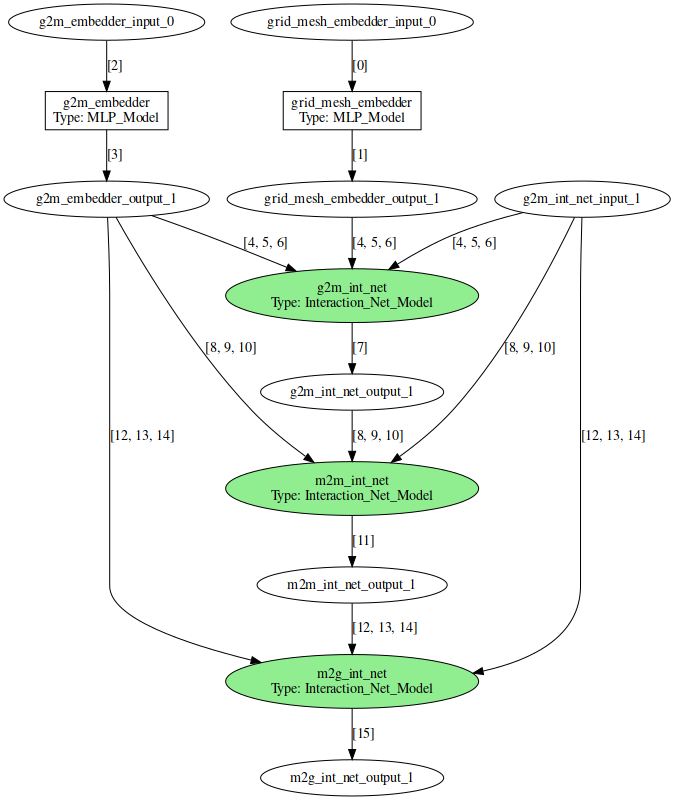

Ensure inputs match the following list {'g2m_embedder_input_0': None, 'g2m_int_net_input_1': None, 'grid_mesh_embedder_input_0': None}
Sub model grid_mesh_embedder has inputs from ['grid_mesh_embedder_input_0']
Sub model g2m_embedder has inputs from ['g2m_embedder_input_0']
Sub model g2m_int_net has inputs from ['grid_mesh_embedder_output_1', 'g2m_int_net_input_1', 'g2m_embedder_output_1']
Sub model m2m_int_net has inputs from ['g2m_int_net_output_1', 'g2m_int_net_input_1', 'g2m_embedder_output_1']
Sub model m2g_int_net has inputs from ['m2m_int_net_output_1', 'g2m_int_net_input_1', 'g2m_embedder_output_1']


14it [00:00, 52288.74it/s]
78it [00:00, 88016.06it/s]
14it [00:00, 53092.46it/s]
78it [00:00, 87032.64it/s]
14it [00:00, 54981.51it/s]
78it [00:00, 89779.28it/s]
14it [00:00, 54776.36it/s]
78it [00:00, 91231.38it/s]


In [24]:
from sdk.ample import Ample

ample = Ample(gpu_sim=True)

model.to_device('ample',data=inputs)

In [25]:
out = model(*inputs)

args Namespace(cpu=False, gpu=True, sim=False, fpga_clk_freq=200000000.0, device=0, preload=False, tb_tolerance=0.01, tb_log_level='INFO', build=False, gui=False, metrics=False)
base path /home/aw1223/


device 0
filename /home/aw1223/timing_tmp.txt
Inference job completed in [0.0019432997795343398, 0.009073739661537046]ms. Terminating power job...
| Component   | Metric           |    Value |
|:------------|:-----------------|---------:|
| gpu         | Gpu Latency Mean | 0.001943 |
